### Import Libraries

In [1]:
import os
import random
from PIL import Image        # for read image files
import matplotlib.pyplot as plt

# base_dir = r'D:\Project03_emotion\data'
base_dir = r'./data'

sub_folders = os.listdir(base_dir)

### Define Emotion Classes
-   Map numerical labels to corresponding emotion names.


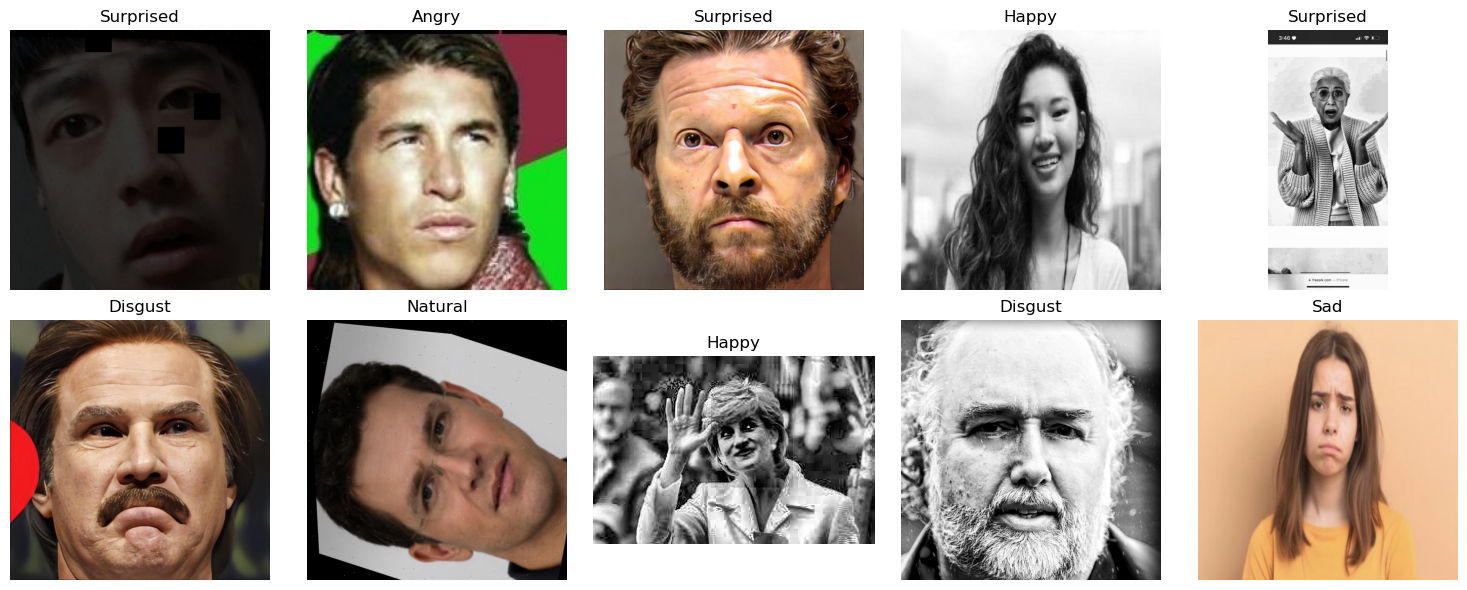

In [2]:

emotion_map = {
    0: 'Angry',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happy',
    5: 'Natural',
    6: 'Sad',
    7: 'Sleepy',
    8: 'Surprised'
}

image_labels = []

for folder in sub_folders:
    image_folder = os.path.join(base_dir, folder, 'images')
    label_folder = os.path.join(base_dir, folder, 'labels')

    if os.path.exists(image_folder) and os.path.exists(label_folder):
        # Ottenere la lista dei file immagine
        image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'    
            label_path = os.path.join(label_folder, label_file)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:           # r = read mode
                    label_data = f.readline().strip().split()
                    if label_data:
                        emotion_id = int(label_data[0])
                        if emotion_id in emotion_map:
                            emotion_label = emotion_map[emotion_id]
                            image_labels.append((image_path, emotion_label))

random.shuffle(image_labels)
sample_images = image_labels[:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()        # change 1 Dimention

for i, (image_path, emotion_label) in enumerate(sample_images):     # enumerate() က i (index) ကို အလိုအလျောက်ထုတ်ပေးတယ်။
    try:
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(emotion_label)
        axes[i].axis('off')
    except FileNotFoundError:
        print(f"File non find: {image_path}")
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

plt.tight_layout()
plt.show()

### Import Required Libraries for Model Training and Evaluation


In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import numpy as np 
from sklearn.utils.class_weight import compute_class_weight

### Define Configurations and Transforms
-   Dataset directory

-   Image size
    
-   Training and validation transformations using transforms.Compose

In [4]:

# valid = used to evaluate your model during training (for tuning).

# Define the main data directory
# data_dir = r'D:\Project03_emotion\data'
data_dir = r'./data'

# Define image size
image_size = 224

# Define data transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.1),  # Randomly convert some images to grayscale with 10% chance
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])


val_transforms = transforms.Compose([
    transforms.Resize(int(image_size * 1.1)),  # Resize slightly bigger for center crop
    transforms.CenterCrop(image_size),         # Crop center to exact image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### Create Custom Dataset Class
-   Loads images and matching emotion labels from separate folders.

-   Matches image files to label .txt files by filename.

-   Applies optional transforms to images.

-   Returns (image, label) pairs for training.

-   Checks that image and label counts match.

In [5]:
class CustomFacialExpressionDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

        print(f"Found {len(self.img_files)} image files in: {img_dir}")
        print(f"Found {len(self.label_files)} label files in: {labels_dir}")

        self.emotion_labels = self._load_emotion_labels()                   #load emotion labels from text files
        assert len(self.img_files) == len(self.emotion_labels), f"Number of images ({len(self.img_files)}) and loaded labels ({len(self.emotion_labels)}) do not match" #AssertionError --> image count နဲ့ label count တူမတူစစ်

    def _load_emotion_labels(self):
        emotion_labels = {}
        for img_file in self.img_files:
            img_name_base = os.path.splitext(img_file)[0]
            label_file = img_name_base + '.txt'
            label_path = os.path.join(self.labels_dir, label_file)          # os.path.join() က folder + filename ကို combine လုပ်တယ်။
                                                                            # eg "dataset/labels/image1.txt"
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label_data = f.readline().strip().split()               # 3 0.7 0.2" ---> ['3', '0.7', '0.2']
                    if label_data:
                        emotion_id = int(label_data[0])
                        emotion_labels[img_file] = emotion_id
            else:
                print(f"Warning: Label file not found for image: {img_file}")
        return emotion_labels

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):                         # work with image file
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.emotion_labels[img_name]
        if self.transform:                          # if transform is not None  
            image = self.transform(image)
        return image, label                         # return image tensor and label (emotion id


### Set Up Dataset Paths and Create Dataset Instances
-   Specifies paths to training/validation image-label folders and initializes datasets.

In [6]:
# Define paths for train and validation images and labels
train_img_dir = os.path.join(data_dir, 'train', 'images')
train_labels_dir = os.path.join(data_dir, 'train', 'labels')
valid_img_dir = os.path.join(data_dir, 'valid', 'images')
valid_labels_dir = os.path.join(data_dir, 'valid', 'labels')

# Create Custom Datasets
print("Creating Custom Datasets...")
train_dataset = CustomFacialExpressionDataset(train_img_dir, train_labels_dir, transform=train_transforms)
val_dataset = CustomFacialExpressionDataset(valid_img_dir, valid_labels_dir, transform=val_transforms)
print("Custom Datasets created.")


Creating Custom Datasets...
Found 64864 image files in: ./data/train/images
Found 64866 label files in: ./data/train/labels
Found 1720 image files in: ./data/valid/images
Found 1720 label files in: ./data/valid/labels
Custom Datasets created.


### Initialize DataLoaders
-   Creates train_loader and val_loader for batching and shuffling.


In [7]:
# Define class names
class_names = [f'Emotion {i}' for i in range(9)]            # Assuming 9 classes, you can modify this based on your dataset
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Create DataLoaders
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)    # data load with 2 CPU threads (num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
print("DataLoaders created.")


Number of classes: 9
Class names: ['Emotion 0', 'Emotion 1', 'Emotion 2', 'Emotion 3', 'Emotion 4', 'Emotion 5', 'Emotion 6', 'Emotion 7', 'Emotion 8']
Creating DataLoaders...
DataLoaders created.


### Load and Modify Pretrained ResNet-50
-   Load pretrained ResNet-50
-   Freeze most layers
-   Replace final FC layer with nn.Linear(num_ftrs, num_classes)

In [8]:
# Load the pre-trained ResNet-18 model
print("Loading pre-trained ResNet-18 model...")

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)       # ResNet50_Weights.DEFAULT is used to load the pre-trained weights

print("Pre-trained ResNet-18 model loaded.")

# Freeze parameters of all layers except the last fully connected layer
print("Freezing layers except the last fully connected layer...")
for name, param in model.named_parameters():            # fc = final fully connected layer
    if "layer4" in name or "fc" in name:
        param.requires_grad = True                      # Faster training, less overfitting.
    else:
        param.requires_grad = False

print("Layers frozen.")

# Modify the last fully connected layer to match the number of classes
print("Modifying the last fully connected layer...")
num_ftrs = model.fc.in_features                     # Last layer input feature size ကို သိမ်းထားတယ်
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)                                       # Last layer ကို 9-class classifier
print("Last fully connected layer modified.")


Loading pre-trained ResNet-18 model...
Pre-trained ResNet-18 model loaded.
Freezing layers except the last fully connected layer...
Layers frozen.
Modifying the last fully connected layer...
Last fully connected layer modified.


### Define Device, Loss, and Optimizer
-   Loss: CrossEntropyLoss

-   Optimizer: Adam

In [9]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define the loss function and optimizer
print("Defining loss function and optimizer...")   

# Compute class weights
labels = list(train_dataset.emotion_labels.values())
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Update loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)                        # use CrossEntropyLoss for multi-class classification
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, weight_decay=1e-4) # Optimize only the parameters of the last layer
print("Loss function and optimizer defined.")



Using device: cpu
Defining loss function and optimizer...
Loss function and optimizer defined.


### Train and Validate the Model with Early Stopping and Learning Rate Scheduling

-   Learning rate scheduler setup using StepLR

-   Early stopping mechanism to prevent overfitting

-   Full training and validation loop:

    -   Forward and backward passes

    -   Accuracy and loss calculation

    -   Evaluation with validation set

    -   Saving the best model

    -   Applying scheduler step

In [ ]:

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Early stopping parameters
patience = 3                        # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')        # Validation loss မှာ best ဖြစ်တဲ့ တန်ဖိုးကို သိမ်းထားတယ်။
epochs_no_improve = 0               

# | Epoch | Val Loss | Action                   | `epochs_no_improve` |
# | ----- | -------- | ------------------------ | ------------------- |
# | 1     | 0.50     | Best so far → Save model | 0                   |
# | 2     | 0.48     | Improved → Save model    | 0                   |
# | 3     | 0.48     | Not improved             | 1                   |
# | 4     | 0.52     | Not improved             | 2                   |
# | 5     | 0.53     | Not improved             | 3 → Early Stop!     |


train_losses = []
val_losses = []
# Training loop
num_epochs = 1
print("Starting training loop...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}: Training...")
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_bar = tqdm(train_loader)
    for inputs, labels in train_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()               # Reset gradients to zero before backward pass

        outputs = model(inputs)             # Forward pass
        loss = criterion(outputs, labels)   # Compute loss
        loss.backward()                     # Backward pass
        optimizer.step()                    # Update weights

        running_loss += loss.item() * inputs.size(0) # Aggregate loss  --> total loss calculation အတွက်


        # count how many predictions were correct --> calculate accuracy
        _, predicted_train = torch.max(outputs.data, 1) 
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

        # Predicted: [2, 0, 1]
        # Labels: [2, 1, 1]
        # Matches: [True, False, True] → .sum() = 2

        train_accuracy = 100 * correct_train / total_train

        train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'accuracy': f'{train_accuracy:.2f}%'})

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)

    epoch_accuracy_train = 100 * correct_train / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy_train:.2f}%')

    # Validation phase
    print(f"Epoch {epoch+1}/{num_epochs}: Validation...")
    model.eval()
    correct_val = 0
    total_val = 0
    all_preds = []          # Model ရဲ့ prediction တွေစုထားတာ ---> accuracy မလွဲစေဖို့
    all_labels = []         # True labels တွေစုထားတာ ---> accuracy မလွဲစေဖို့
    val_loss = 0.0
    val_bar = tqdm(val_loader)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
            accuracy_val = 100 * correct_val / total_val
            val_bar.set_postfix({'accuracy': f'{accuracy_val:.2f}%'})

            # Collect predictions and labels for confusion matrix
            all_preds.extend(predicted_val.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_accuracy_val = 100 * correct_val / total_val
    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_accuracy_val:.2f}%')

    # Early stopping check and save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Validation loss improved. Saving model to best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break
    
    val_acc = epoch_accuracy_val
    if isinstance(val_acc, torch.Tensor):
        val_acc = val_acc.item()

    scheduler.step(epoch_accuracy_val)


/home/hmuegyi/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting training loop...
Epoch 1/1: Training...


 76%|███████████████████████████████████████████████████████▉                  | 1531/2027 [24:41<07:25,  1.11it/s, loss=1.2108, accuracy=49.02%]

### for comapre train loss and val loss

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='s', linestyle='-', color='orange', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate Best Model and Visualize Confusion Matrix

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

class_names = ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Natural', 'Sad', 'Sleepy', 'Surprised']

# Calculate and visualize the confusion matrix on the validation set
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print('Finished Training and Saving Best Model')


###  Visualize Random Predictions: True vs Predicted Labels

In [ ]:
# Visualize 10 random images with true and predicted labels
def visualize_predictions(model, val_dataset, class_names, num_images=10):      # model က ဘယ်အမျိုးအစားတွေကို မမှန်ခန့်မှန်းတာ ရှင်းလင်းစေဖို့
    plt.figure(figsize=(15, 6))
    indices = random.sample(range(len(val_dataset)), num_images)
    for i, index in enumerate(indices):
        image, true_label = val_dataset[index]
        model.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = class_names[predicted.item()]
            true_label_name = class_names[true_label]

        ax = plt.subplot(2, num_images // 2, i + 1)
        image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
        ax.imshow(image_np)
        ax.set_title(f'True: {true_label_name}\nPred: {predicted_label}', fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model.to(device), val_dataset, class_names, num_images=10)

### predit with filepath photo

In [ ]:
from torchvision.transforms.functional import to_pil_image

# --- Test with your own image ---
def predict_image(model, image_path, transform, class_names):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()
    
    # Show image
    plt.imshow(image)
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

    # Show probabilities
    print("Prediction Probabilities:")
    for i, prob in enumerate(probabilities):
        print(f"{class_names[i]}: {prob.item()*100:.2f}%")

# Load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# ✅ Set your own test image path
your_image_path = r'D:\Project03_emotion\your_test_image.jpg'  # <-- change this

# Predict using the validation transform
predict_image(model, your_image_path, val_transforms, class_names)


### Real-Time Emotion Detection from Webcam using Trained Model

In [ ]:
import cv2
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import numpy as np

# Define emotion class names
class_names = [
    'Angry',
    'Contempt',
    'Disgust',
    'Fear',
    'Happy',
    'Natural',
    'Sad',
    'Sleepy',
    'Surprised'
]

# Define image size and transform
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Load the trained model
num_classes = len(class_names)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(128, num_classes)
)   

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval().to(device)

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Mirror the frame horizontally
    frame = cv2.flip(frame, 1)

    # Convert frame to PIL image
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
        label = class_names[predicted_class.item()]

    # Show predicted label on video
    cv2.putText(frame, f'Emotion: {label}', (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Emotion Detection', frame)

    # Break on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


In [ ]:
# import os
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms, models
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2  # OpenCV for heatmap overlay
# import random

# # Define the main data directory
# data_dir = './data'

# # Define image size
# image_size = 224

# # Define data transformations (without normalization for CAM visualization)
# transform_cam = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
# ])

# # Define class names
# class_names = [
#     'Angry',
#     'Contempt',
#     'Disgust',
#     'Fear',
#     'Happy',
#     'Natural',
#     'Sad',
#     'Sleepy',
#     'Surprised'
# ]
# num_classes = len(class_names)
# print(f"Number of classes: {num_classes}")
# print(f"Class names: {class_names}")

# class CustomFacialExpressionDataset(Dataset):
#     def __init__(self, img_dir, labels_dir, transform=None):
#         self.img_dir = img_dir
#         self.labels_dir = labels_dir
#         self.transform = transform
#         self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
#         self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])
#         self.emotion_labels = self._load_emotion_labels()

#     def _load_emotion_labels(self):
#         emotion_labels = {}
#         for img_file in self.img_files:
#             img_name_base = os.path.splitext(img_file)[0]
#             label_file = img_name_base + '.txt'
#             label_path = os.path.join(self.labels_dir, label_file)
#             if os.path.exists(label_path):
#                 with open(label_path, 'r') as f:
#                     label_data = f.readline().strip().split()
#                     if label_data:
#                         emotion_id = int(label_data[0])
#                         emotion_labels[img_file] = emotion_id
#         return emotion_labels

#     def __len__(self):
#         return len(self.img_files)

#     def __getitem__(self, idx):
#         img_name = self.img_files[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')
#         label = self.emotion_labels[img_name]
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # Define paths for validation images and labels
# valid_img_dir = os.path.join(data_dir, 'valid', 'images')
# valid_labels_dir = os.path.join(data_dir, 'valid', 'labels')

# # Create Validation Dataset for CAM
# val_dataset_cam = CustomFacialExpressionDataset(valid_img_dir, valid_labels_dir, transform=transform_cam)
# val_loader_cam = DataLoader(val_dataset_cam, batch_size=4, shuffle=True) # Reduced batch size for visualization

# # Load the best trained ResNet-18 model
# model = models.resnet18(weights=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('best_model.pth', map_location=device))
# model.eval().to(device)

# # Function to get the feature maps of the last convolutional layer
# last_conv_layer_name = 'layer4'
# feature_maps = {}
# def get_feature_maps(name):
#     def hook(module, input, output):
#         feature_maps[name] = output.detach()
#     return hook

# # Register the hook to get the feature maps of the last convolutional layer
# layer = model._modules.get(last_conv_layer_name)
# handle = layer.register_forward_hook(get_feature_maps(last_conv_layer_name))

# def generate_cam(model, input_tensor, target_class):
#     output = model(input_tensor)
#     _, predicted_class = torch.max(output, 1)

#     # Get the feature maps of the last convolutional layer
#     conv_output = feature_maps[last_conv_layer_name]

#     # Get the weights of the fully connected layer for the target class
#     weights = model.fc.weight[target_class].detach()

#     # Generate the CAM
#     cam = torch.mul(conv_output, weights.unsqueeze(0).unsqueeze(2).unsqueeze(3)).sum(dim=1, keepdim=True)
#     cam = torch.relu(cam) # ReLU to consider only positive activations
#     cam = cam - torch.min(cam)
#     cam = cam / (torch.max(cam) + 1e-7) # Normalize between 0 and 1

#     return cam.squeeze().cpu().numpy(), predicted_class.item()

# def show_cam_on_image(img_tensor, heatmap):
#     img = img_tensor.permute(1, 2, 0).cpu().numpy()
#     img = (img - np.min(img)) / (np.max(img) - np.min(img)) # Normalize original image

#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Explicitly convert heatmap to the same data type as img
#     heatmap_float = heatmap.astype(np.float32) / 255.0
#     cam = cv2.addWeighted(img.astype(np.float32), 0.6, heatmap_float, 0.4, 0)
#     return cam

# # Visualize the CAMs for some example images
# num_images_to_show = 4
# dataiter_cam = iter(val_loader_cam)
# images, true_labels = next(dataiter_cam)
# images = images.to(device)

# fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 5 * num_images_to_show))

# for i in range(num_images_to_show):
#     input_tensor = images[i].unsqueeze(0)
#     true_label = true_labels[i].item()

#     # Generate CAM for the true class
#     cam_true, _ = generate_cam(model, input_tensor, true_label)
#     cam_image_true = show_cam_on_image(images[i].cpu(), cam_true)

#     # Generate CAM for the predicted class
#     with torch.no_grad():
#         output = model(input_tensor)
#         _, predicted_class = torch.max(output, 1)
#         cam_pred, _ = generate_cam(model, input_tensor, predicted_class.item())
#         cam_image_pred = show_cam_on_image(images[i].cpu(), cam_pred)

#     axes[i, 0].imshow(cam_image_true)
#     axes[i, 0].set_title(f'True: {class_names[true_label]}')
#     axes[i, 0].axis('off')

#     axes[i, 1].imshow(cam_image_pred)
#     axes[i, 1].set_title(f'Predicted: {class_names[predicted_class.item()]}')
#     axes[i, 1].axis('off')

# plt.tight_layout()
# plt.show()

# # Remove the hook
# handle.remove()

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FakeData
from torchvision import transforms

# Create a dummy dataset
transform = transforms.ToTensor()
dataset = FakeData(size=100, image_size=(3, 64, 64), num_classes=10, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, num_workers=2)

# Print number of workers
print("Number of workers:", dataloader.num_workers)


Number of workers: 2
